**Franco Ortiz** :Data scientist

UFO-reports-analysis
# Problem Statement
### Questions to answer
- What time is more frequent to see them?
- How long did the experience take?
- What shapes are most common and where?
- Top words that described that moment (wordcloud)
- heat map with quantities and cities for number of sightings

# Data importing
#### modules

In [20]:
import pandas as pd
import datetime as dt
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from dataprep.clean import clean_date
import re

# set seed for reproducibility
np.random.seed(0)

In [3]:
df = pd.read_csv("data/ufo.csv", keep_default_na=True)
df.head(20)

,Date / Time,City,State,Country,Shape,Duration,Summary,Posted,Images
0,00:00,Dieppe (Moncton) (Canada),NB,Canada,Oval,NaN,((HOAX??)) we wher looking .. in the sky in di...,9/24/12,NaN
1,4/ 23:22,Atlantic City,NJ,USA,Disk,30 minutes,Observed a very bright white saucer (had two l...,5/6/17,NaN
2,03142020 23:04,Norwich,VT,USA,Circle,97 seconds,Strange sighting in the sky,5/15/20,NaN
3,1970s 23:00,Grande Summit,PA,USA,Light,5 minutes,4 lights speeding very fast across sky silently,8/16/21,NaN
4,23:00,Desolation Wilderness,CA,USA,Triangle,2 min.,triangle of lights moving slowly through the n...,9/15/05,NaN
5,23:00,Playa del Rey,CA,USA,Fireball,3-5 seconds,"Neon green, long-tailed fireball meteor-lookin...",7/8/04,NaN
6,23:00,Milltown (Canada),NB,Canada,Circle,NaN,"I wonder where they are today, and if they are...",6/4/04,NaN
7,23:00,Manning,SC,USA,Sphere,2 minutes,The object was metallic in color. Spherical in...,6/25/20,NaN
8,23:00,New Alexandria,PA,USA,Other,15 minutes,Translucent UFO.,5/9/19,NaN
9,23:00,"Northern California Coast (in, highway)",CA,USA,Cigar,3-5 min.,We were travelling along the coast of Californ...,10/2/99,NaN


- As we see index 1,2,3,4 must be put in an standard format

In [113]:
df.columns

Index(['Date / Time', 'City', 'State', 'Country', 'Shape', 'Duration',
       'Summary', 'Posted', 'Images'],
      dtype='object')

In [115]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 138298 entries, 0 to 138297
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   Date / Time  138197 non-null  object
 1   City         137909 non-null  object
 2   State        128886 non-null  object
 3   Country      138075 non-null  object
 4   Shape        132096 non-null  object
 5   Duration     131537 non-null  object
 6   Summary      138227 non-null  object
 7   Posted       138296 non-null  object
 8   Images       524 non-null     object
dtypes: object(9)
memory usage: 9.5+ MB


# Data Cleaning

#### splitting datetime column

In [116]:
# print the first few rows of the date column
print(df['Date / Time'].head())

0             00:00
1          4/ 23:22
2    03142020 23:04
3       1970s 23:00
4             23:00
Name: Date / Time, dtype: object


In [117]:
# check the data type of our date column
print(df['Date / Time'].dtype)

object


#### column values to lowercase

In [4]:
for column in df.columns:
    df[column] = df[column].str.lower()
df.head()

,Date / Time,City,State,Country,Shape,Duration,Summary,Posted,Images
0,00:00,dieppe (moncton) (canada),nb,canada,oval,NaN,((hoax??)) we wher looking .. in the sky in di...,9/24/12,NaN
1,4/ 23:22,atlantic city,nj,usa,disk,30 minutes,observed a very bright white saucer (had two l...,5/6/17,NaN
2,03142020 23:04,norwich,vt,usa,circle,97 seconds,strange sighting in the sky,5/15/20,NaN
3,1970s 23:00,grande summit,pa,usa,light,5 minutes,4 lights speeding very fast across sky silently,8/16/21,NaN
4,23:00,desolation wilderness,ca,usa,triangle,2 min.,triangle of lights moving slowly through the n...,9/15/05,NaN


#### cleaning Summary column

In [17]:
# return only words if them are str, if not '', using regular expression
# (r'\b\w+\b', x) words and digits
df['words'] = df['Summary'].apply(lambda x: re.findall(r'[^\d\W]+', x) if isinstance(x, str) else [])
df['words']

0         [hoax, we, wher, looking, in, the, sky, in, di...
1         [observed, a, very, bright, white, saucer, had...
2                         [strange, sighting, in, the, sky]
3         [lights, speeding, very, fast, across, sky, si...
4         [triangle, of, lights, moving, slowly, through...
                                ...                        
138293    [two, lights, shaped, like, dots, flying, abov...
138294    [red, dots, with, a, white, blur, glow, surrou...
138295    [two, golden, orbs, movin, slowly, one, a, bit...
138296    [object, observed, flying, southwest, to, nort...
138297    [objects, off, flight, path, rotating, most, l...
Name: words, Length: 138298, dtype: object

# EDA

### what shapes are most common and where 

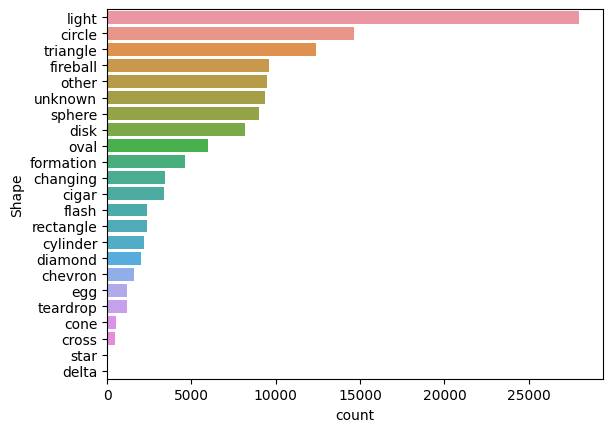

In [120]:
sns.countplot(y ='Shape', 
              data = df, 
              order = df['Shape'].value_counts().index)
plt.show()

In [121]:
# Top 15 places
shapes_where = df.groupby(['City'])['Shape'].value_counts().sort_values(ascending=False).head(15)
shapes_where

City          Shape 
seattle       light     146
phoenix       light     145
las vegas     light     133
portland      light     129
san diego     light     118
tucson        light      98
los angeles   light      96
myrtle beach  light      90
orlando       light      75
springfield   light      74
miami         light      72
albuquerque   light      71
houston       light      70
portland      circle     70
las vegas     circle     69
Name: Shape, dtype: int64

- Seems like most common shape is 'light-shaped', followe by circle and triangle. The top 3 places they are seen is in Seattle, Phoenix, Las Vegas

### Most used words in description
Text Mining with NLTK, and frecuency distribution

In [24]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from PIL import Image

In [ ]:
# for WordCloud.generate() method should be a single string
words_string = ' '.join(df['words'].str.join(' '))
wc.generate(words_string)

In [ ]:
wc = WordCloud(background_color='white', max_font_size=50)
wc.generate(df['words'])

plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.show()

# Feature Engineering

# Modelling

# Communication